In [1]:
import joblib

metadata_corpus = joblib.load("live/metadata_corpus_live.pkl")

In [2]:
host_embeddings = []
host_labels = []
for ip, ip_doc in metadata_corpus.items():
    host_labels.append(ip)
    host_embeddings.append(ip_doc["embedding"])

In [14]:
host_host_embeddings = []
host_host_labels = []
for ip, ip_doc in metadata_corpus.items():
    for ip2, ip2_doc in ip_doc["documents"].items():
        host_host_labels.append((ip, ip2))
        host_host_embeddings.append(ip2_doc)

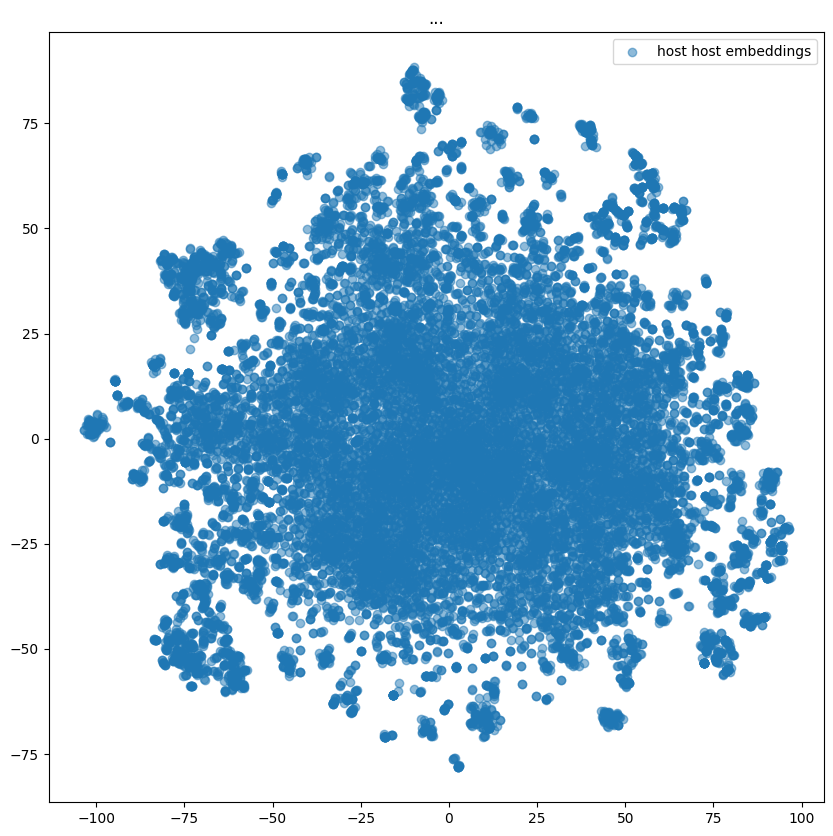

In [18]:
from evaluate_bert import *
visualize_embeddings([host_host_embeddings], ["host host embeddings"], "...", "tsne")

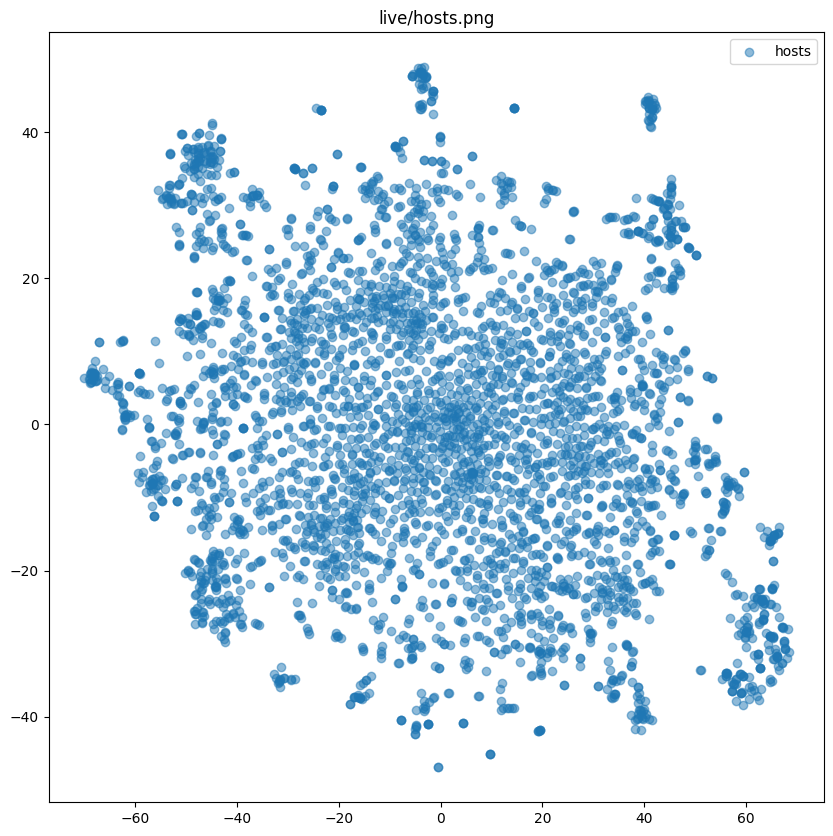

In [6]:
from evaluate_bert import *
visualize_embeddings([host_embeddings], ["hosts"], "live/hosts.png", "tsne")

In [49]:
import pandas as pd

host_rows = []
host_host_rows = []

for i, ip in enumerate(metadata_corpus):
    for score, label in zip(metadata_corpus[ip]["scores"], metadata_corpus[ip]["labels"]):
        host_rows.append({"ip": ip, "score": score, "label": label})
    for ip2, doc in metadata_corpus[ip]["documents_meta"].items():
        for score, label in zip(doc["scores"], doc["labels"]):
            host_host_rows.append({"ip": ip, "ip2": ip2, "score": score, "label": label})

host_df = pd.DataFrame(host_rows)
host_host_df = pd.DataFrame(host_host_rows)
host_df["const"] = 1
host_host_df["const"] = 1

In [50]:
host_host_df
grouped_host = host_df.groupby(["ip", "label"]).agg({
    "score": "mean",  # Mean score for each label
    "const": "size"  # Count of each group
}).reset_index()

In [51]:
print(grouped_host)

                                 ip  label     score  const
0                         1.1.0.248      3  0.831610     10
1                          1.1.0.50      3  0.782977     10
2                           1.1.1.1      3  0.905396     10
3                       1.55.119.42      2  0.802950      1
4                       1.55.119.42      3  0.755360      9
...                             ...    ...       ...    ...
4256                  99.83.218.184      3  0.796870     10
4257  fe80:0:0:0:250:56ff:fe89:bd97      3  0.750830     10
4258  fe80:0:0:0:250:56ff:fe89:d407      3  0.868507     10
4259             ff02:0:0:0:0:0:0:c      3  0.660289     10
4260            ff02:0:0:0:0:0:0:fb      3  0.855461     10

[4261 rows x 4 columns]


In [52]:
# retreive all rows with label 2 and const greater than 5 sorted by score desc
grouped_host[grouped_host["label"] == 2].sort_values("score", ascending=False).query("const > 20")

,ip,label,score,const


In [53]:
host_df[host_df["ip"] == "100.96.1.5"]
pass

In [54]:
host_host_df.head(10)
pass

In [55]:
host_host_df[((host_host_df["ip2"] == "2a07:1182:7:22:0:0:0:20") | (host_host_df["ip2"] == "10.7.22.20"))].query("label == 2").sort_values("score", ascending=False)


,ip,ip2,score,label,const
14883,224.0.0.251,10.7.22.20,0.838867,2,1
11078,212.45.194.115,10.7.22.20,0.806390,2,1
29803,100.101.0.42,10.7.22.20,0.802668,2,1


In [ ]:
# add number of times ip appears as new column


In [56]:
# print all rows with label 2 and score over 0.9
host_host_df.query("label == 2 and score > 0.96")

,ip,ip2,score,label,const
35200,141.193.213.21,10.7.12.26,0.961531,2,1
62120,20.189.173.27,10.7.11.18,1.000000,2,1
66404,13.107.42.16,10.7.12.27,0.963566,2,1
123714,52.85.49.53,10.7.12.21,0.965683,2,1
145820,23.32.25.202,10.7.12.29,0.960180,2,1
164130,192.0.66.160,10.7.12.27,0.988448,2,1


In [45]:
# get the fraction of label 2 for all rows where ip1 is 89.145.160.109 in host_host_df
ip_scores = {}
for ip in host_host_df["ip"].unique():
    num_malicious = host_host_df.query(f"ip == '{ip}' and label == 2")["const"].sum()
    num_benign = host_host_df.query(f"ip == '{ip}' and label == 3")["const"].sum()
    highest_score_malicious = host_host_df.query(f"ip == '{ip}' and label == 2")["score"].max()
    highest_score_benign = host_host_df.query(f"ip == '{ip}' and label == 3")["score"].max()
    if highest_score_malicious > highest_score_benign:
        ip_scores[ip] = num_malicious / (num_malicious + num_benign)

# print out the top 10 ip addresses with the highest fraction of malicious documents
sorted_list = sorted(ip_scores.items(), key=lambda x: x[1], reverse=True)

# write to csv
pd.DataFrame(sorted_list, columns=["ip", "fraction"]).to_csv("live/top_malicious_ips.csv", index=False)

In [46]:
host_host_df.query("ip == '15.230.174.89'")


,ip,ip2,score,label,const
101540,15.230.174.89,10.7.13.14,0.725522,3,1
101541,15.230.174.89,10.7.13.14,0.713083,3,1
101542,15.230.174.89,10.7.13.14,0.709230,3,1
101543,15.230.174.89,10.7.13.14,0.706647,3,1
101544,15.230.174.89,10.7.13.14,0.694347,3,1
101545,15.230.174.89,10.7.13.14,0.686663,3,1
101546,15.230.174.89,10.7.13.14,0.685663,2,1
101547,15.230.174.89,10.7.13.14,0.681405,3,1
101548,15.230.174.89,10.7.13.14,0.681195,3,1
101549,15.230.174.89,10.7.13.14,0.671018,3,1


# Process Feed

In [47]:
# take everything above 0.25 score from sorted_list
with open("good_ips.txt", "r") as f:
    good_ips = f.read().split("\n")

ips = [(ip, score) for ip, score in sorted_list if score > 0.1]
ips = [(ip, score) for (ip, score) in ips if ip not in good_ips]

# check if something changed since the last run
with open("live/threatfeed.csv", "r") as f:
    old_ips = f.read().split("\n")
    old_ips = [ip.split(",")[0] for ip in old_ips]

delta_ips = [(ip, score) for (ip, score) in ips if ip not in old_ips]
print(delta_ips)

pd.DataFrame(ips, columns=["ip", "score"]).to_csv("live/threatfeed.csv", index=False, header=False)

[('84.17.53.155', 0.15)]


In [252]:
# find red team subnets


In [266]:
# get the fraction of label 2 for all rows where ip1 is 89.145.160.109 in host_host_df
ip_scores = {}
for ip in host_host_df["ip"].unique():
    num_malicious = host_host_df.query(f"ip == '{ip}' and label == 2")["const"].sum()
    num_benign = host_host_df.query(f"ip == '{ip}' and label == 3")["const"].sum()
    highest_score_malicious = host_host_df.query(f"ip == '{ip}' and label == 2")["score"].max()
    highest_score_benign = host_host_df.query(f"ip == '{ip}' and label == 3")["score"].max()
    
    ip_scores[ip] = num_malicious / (num_malicious + num_benign)

    if highest_score_malicious > highest_score_benign:
        ip_scores[ip] = -ip_scores[ip]

# print out the top 10 ip addresses with the highest fraction of malicious documents
sorted_list_prefix = sorted(ip_scores.items(), key=lambda x: (x[0], x[1]), reverse=True)

# write to csv


In [268]:
df_prefix = pd.DataFrame(sorted_list_prefix, columns=["ip", "fraction"]).to_csv("live/top_malicious_ips_prefix.csv", index=False)

In [258]:
df_prefix = pd.DataFrame(sorted_list_prefix, columns=["ip", "fraction"])

In [264]:
# drop all rows with score < 0.1
df_prefix = df_prefix[df_prefix["fraction"] > 0.3]

In [265]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df_prefix

,ip,fraction
336,52.219.169.122,0.40
737,2a07:1182:101:0:0:0:1:21,0.50
890,2a02:26f0:e2:0:0:0:5f65:8ea9,0.60
967,2a02:2350:6:0:0:0:6514:e26d,0.40
975,2a01:4d40:d0b8:e747:c42c:8bfa:dddb:f1e3,0.40
1040,2a00:1450:4026:803:0:0:0:2016,0.35
1194,2606:4700:3035:0:0:0:6815:2a20,0.50
1303,2606:4700:0:0:0:0:6812:8e77,0.40
1310,2606:4700:0:0:0:0:6812:1e4e,0.40
2460,163.181.0.252,0.60
